# 2. Data Preparation, EDA, and Initial Models

Imports

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import plotly.express as px

import random
np.random.seed(123)
random.seed(123)

from sklearn.model_selection import train_test_split

# import tqdm to visualize progress in loops
from tqdm import tqdm

# Filter warnings
import warnings
warnings.filterwarnings('ignore')

import time

# Print all columns of a datafame
pd.set_option('display.max_columns', None)

# Table of Contents
* [Introduction](#introduction)
* [Data Loading and Cleaning](#data-loading-and-cleaning)
* [EDA](#eda)
* [Feature Engineering](#feature-engineering)
* [Correlation between the Numerical Columns](#correlation)
* [Baseline Logistic Regression](#baseline-model)

---

## Introduction <a id="introduction"></a>

**Streamlining Renewable Energy Site Selection with ML:
Predict the Suitability of Solar Energy Resources**

The goal of this project is to apply machine learning techniques to classify whether solar is suitable as the primary energy source for a location.

This can help energy decision makers and energy companies to simplify the complex site selection process, thereby accelerating the transition to clean and sustainable energy sources, ultimately contributing to the fight against climate change and energy crisis. 

This notebook will look at extreme values in the data that could be caused by data error, conduct detailed EDA to look at the distribution of the numerical columns and the correlation between them, and perform feature engineering to prepare the data further for models.


---

## Data Loading and Cleaning <a id="data-loading-and-cleaning"></a>

### Data Loading

The data set is stored as a `.csv` file. We can load the data using `pd.read_csv()`.

In [62]:
# read the csv into a pandas dataframe
df_cleaned = pd.read_csv("./data/capstone_data_cleaned.csv")

In [63]:
df_shape = df_cleaned.shape
cat_cols = len(df_cleaned.select_dtypes('object').columns)
num_cols = len(df_cleaned.select_dtypes('number').columns)

print(f'Rows: {df_shape[0]}')
print(f'Columns: {df_shape[1]}\n')

print(f'Total duplicate rows: {df_cleaned.duplicated().sum()}')
print(f'Percentage duplicate rows: {df_cleaned.duplicated().mean()}% \n')

print(f'Total null values: {df_cleaned.isna().sum().sum()}')
print(f'Percentage null vales: {df_cleaned.isna().mean().sum()}% \n')

df_cleaned.info()

print("\n")

print(f'Number of categorical columns: {cat_cols}')
print(f'Number of numerical columns: {num_cols}')

Rows: 7788
Columns: 11

Total duplicate rows: 0
Percentage duplicate rows: 0.0% 

Total null values: 0
Percentage null vales: 0.0% 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7788 entries, 0 to 7787
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PrimSource        7788 non-null   object 
 1   State             7788 non-null   object 
 2   Longitude         7788 non-null   float64
 3   Latitude          7788 non-null   float64
 4   WindSpeed         7788 non-null   float64
 5   WindPowerDensity  7788 non-null   float64
 6   SolarRadiation    7788 non-null   float64
 7   AirTemperature    7788 non-null   float64
 8   CloudCoverIndex   7788 non-null   int64  
 9   Elevation         7788 non-null   float64
 10  Slope             7788 non-null   float64
dtypes: float64(8), int64(1), object(2)
memory usage: 669.4+ KB


Number of categorical columns: 2
Number of numerical columns: 9


---

## EDA <a id="eda"></a>

### Distribution of the Numerical Columns

In [64]:
numericalCols = df_cleaned.select_dtypes('number').columns
numericalCols

Index(['Longitude', 'Latitude', 'WindSpeed', 'WindPowerDensity',
       'SolarRadiation', 'AirTemperature', 'CloudCoverIndex', 'Elevation',
       'Slope'],
      dtype='object')

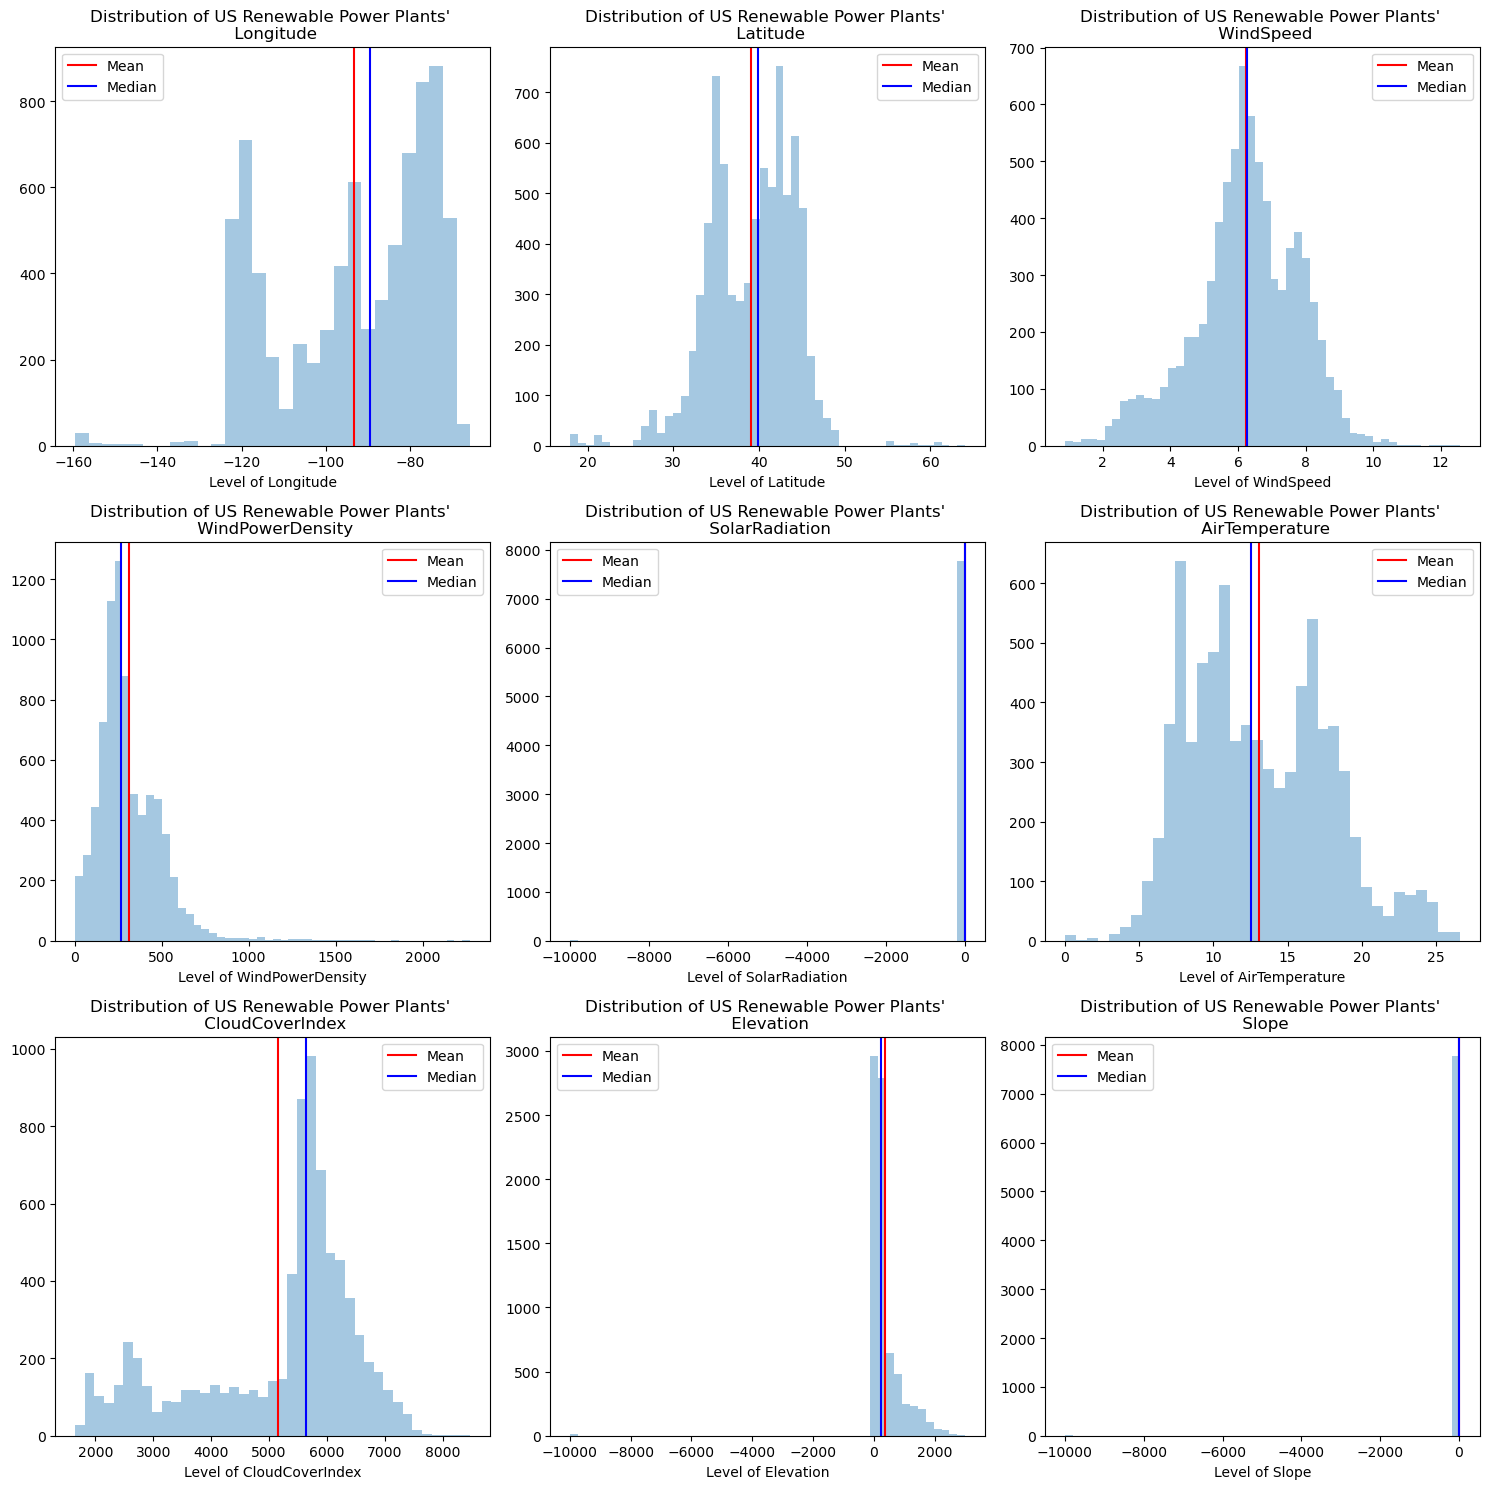

In [65]:
# Set number of rows and columns in subplot
sub_rows = 3
sub_cols = 3

# Set up grid of subplots
plt.subplots(sub_rows, sub_cols, figsize=(sub_cols*5, sub_rows*5))

# Initialize counter
subplot_ctr = 1

# Loop through column names in list
for col in numericalCols:
    
    # Save column values, mean, and median to variables
    var = df_cleaned[col]
    var_mean = var.mean()
    var_median = var.median()

    # Plot subplot in next location in grid
    plt.subplot(sub_rows, sub_cols, subplot_ctr)

    # Plot a histogram of song tempo, with lines marking mean and median
    sns.distplot(var, kde=False)
    plt.axvline(var_mean, c='r', label='Mean')
    plt.axvline(var_median, c='b', label='Median')
    plt.legend()
    
    # Add title and axis label
    plt.xlabel(f'Level of {col}')
    plt.title(f"Distribution of US Renewable Power Plants' \n {col}")
    
    # Add 1 to counter
    subplot_ctr += 1

# This ensures the subplots do not overlap
plt.tight_layout()

plt.show()

We can see from the distribution plots that there are some extreme values for `SolarRadiation`, `Elevation`, and `Slope`. These values seem to be unreasonable.

### Inspect extreme values for Solar Radiation

In [66]:
df_cleaned['SolarRadiation'][df_cleaned['SolarRadiation'] < 0].value_counts()

-9999.0    10
Name: SolarRadiation, dtype: int64

Negative Solar Radiation is not reasonable and the values can't be -9999. These values can be considered as errors and should be replaced as NaN.

In [67]:
# replace the the value of -9999.0 with NaN
df_cleaned['SolarRadiation'] = df_cleaned['SolarRadiation'].replace(-9999.0, np.nan)

# sanity check
(df_cleaned['SolarRadiation'] < 0).sum()

0

### Inspect extreme values for Elevation

In [68]:
df_cleaned['Elevation'][df_cleaned['Elevation'] < 0].value_counts()

-9999.00    10
-69.57       3
-3.29        2
-59.90       2
-43.36       2
            ..
-15.89       1
-3.06        1
-0.07        1
-17.18       1
-7.62        1
Name: Elevation, Length: 62, dtype: int64

It is possible to get negative elevations for some of the power plants, but -9999.00 elevation doesn't make sense. Similar to Solar Radiation, these values are considered as errors and should be replaced with null.

In [69]:
(df_cleaned['Elevation'] == -9999.000000).sum()

10

In [70]:
# replace the values of -9999.000000 with NaN
df_cleaned['Elevation'] = df_cleaned['Elevation'].replace(-9999.000000, np.nan)

# sanity check
(df_cleaned['Elevation'] == -9999.000000).sum()

0

### Inspect extreme values for Slope

In [71]:
df_cleaned['Slope'][df_cleaned['Slope'] < 0].value_counts()

-9999.0    10
Name: Slope, dtype: int64

Negative Slope is not reasonable and the values can't be -9999. These values can be considered as errors and should be replaced as NaN.

In [72]:
# replace the values of -9999.0 with NaN
df_cleaned['Slope'] = df_cleaned['Slope'].replace(-9999.0, np.nan)

# sanity check
(df_cleaned['Slope'] < 0).sum()

0

After we have replaced the extreme values with null values, let's check if that improves the distributions:

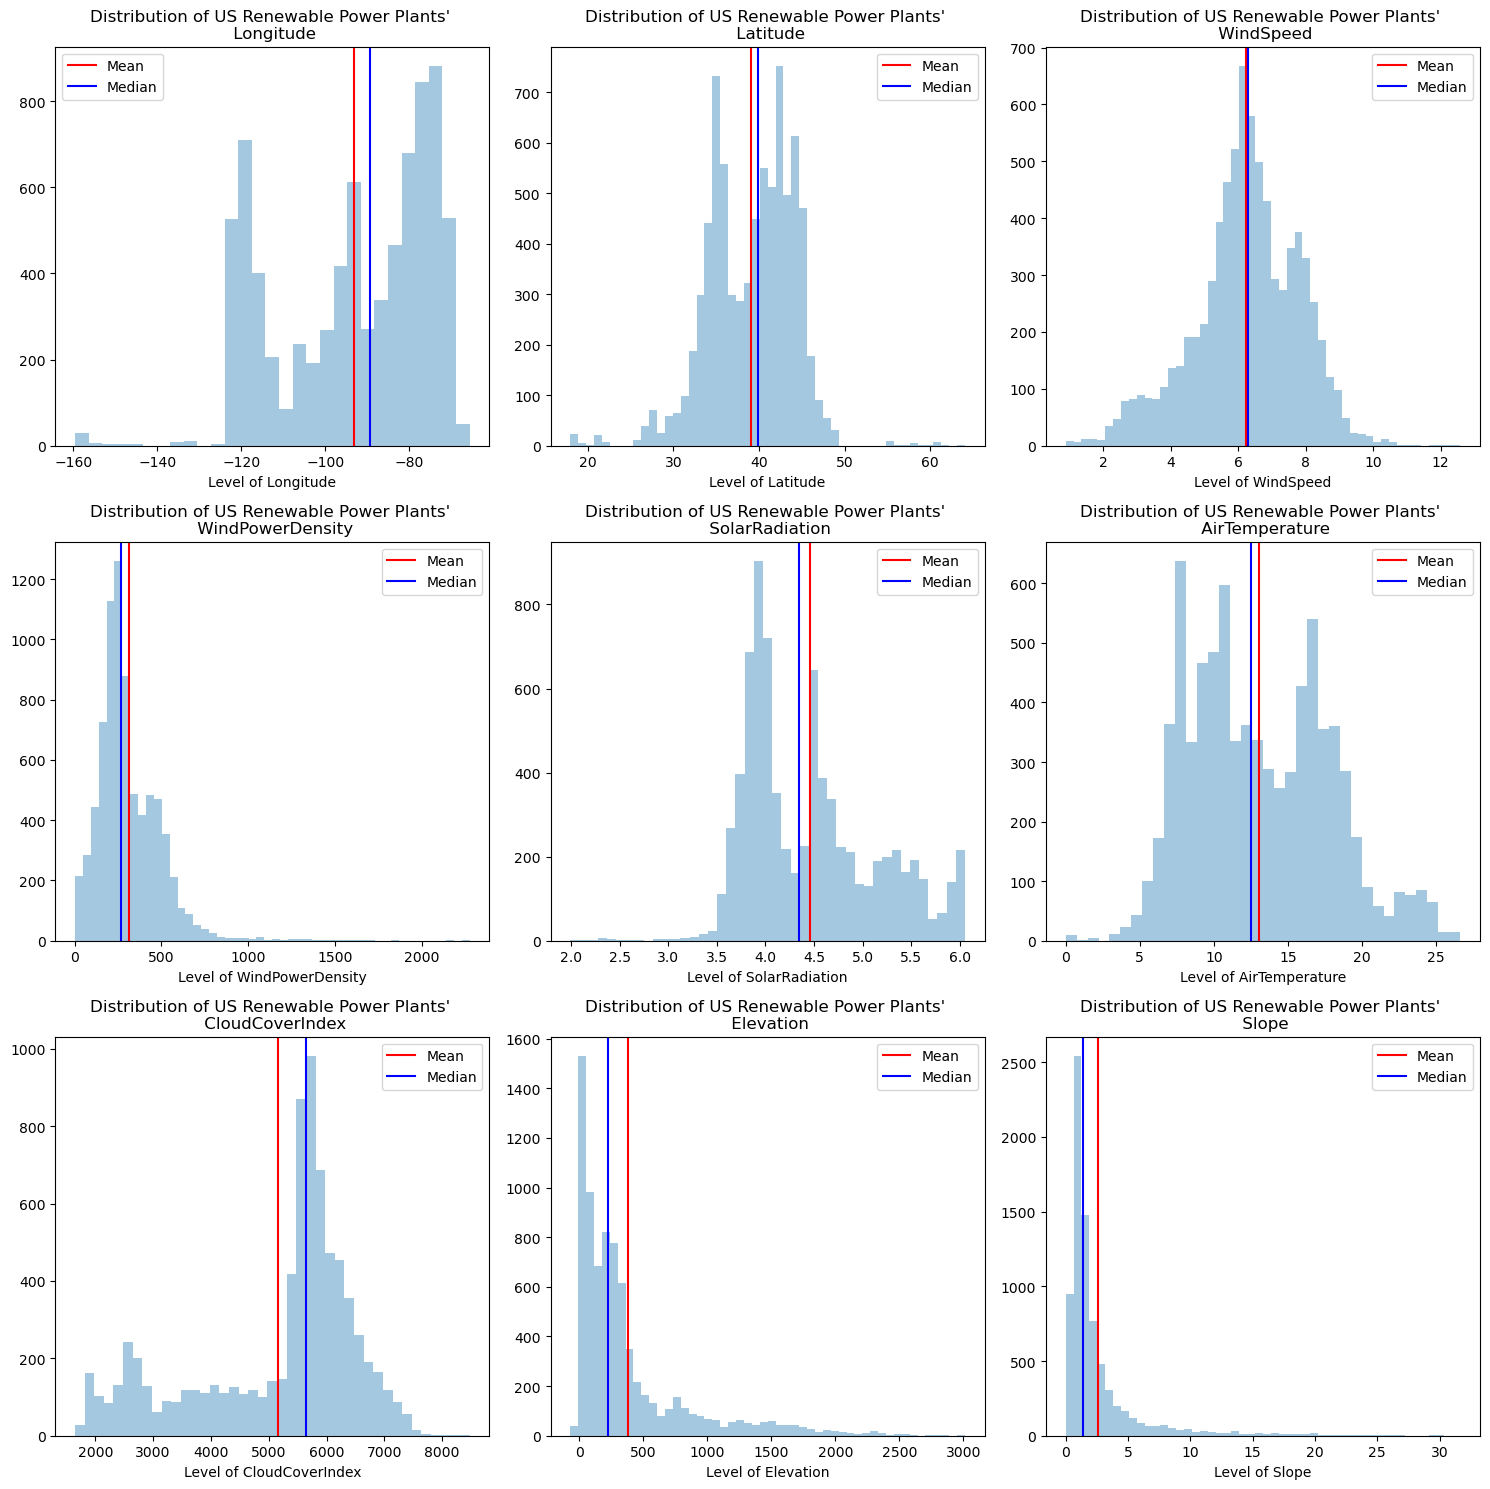

In [73]:
# Set number of rows and columns in subplot
sub_rows = 3
sub_cols = 3

# Set up grid of subplots
plt.subplots(sub_rows, sub_cols, figsize=(sub_cols*5, sub_rows*5))

# Initialize counter
subplot_ctr = 1

# Loop through column names in list
for col in numericalCols:
    
    # Save column values, mean, and median to variables
    var = df_cleaned[col]
    var_mean = var.mean()
    var_median = var.median()

    # Plot subplot in next location in grid
    plt.subplot(sub_rows, sub_cols, subplot_ctr)

    # Plot a histogram of song tempo, with lines marking mean and median
    sns.distplot(var, kde=False)
    plt.axvline(var_mean, c='r', label='Mean')
    plt.axvline(var_median, c='b', label='Median')
    plt.legend()
    
    # Add title and axis label
    plt.xlabel(f'Level of {col}')
    plt.title(f"Distribution of US Renewable Power Plants' \n {col}")
    
    # Add 1 to counter
    subplot_ctr += 1

# This ensures the subplots do not overlap
plt.tight_layout()

plt.show()

After replacing the extreme values with null values, the distribution plots look more reasonable. From the plots we are able to see that only the `WindSpeed` column is somewhat normally distributed. `WindPowerDensity`, `Elevation`, and `Slope` are skewed right, which is an expected result. Other columns are unevenly distributed with potential multiple nodes.

Before we continue to do further EDA, let's fill the null values with the median of the values by their primary energy source class.

### Fill the NaN in each factor column based on the Primary Source median column

View null values

In [74]:
df_cleaned.isna().sum().index[df_cleaned.isna().sum() > 0]

Index(['SolarRadiation', 'Elevation', 'Slope'], dtype='object')

In [75]:
for col in df_cleaned.isna().sum().index[df_cleaned.isna().sum() > 0]:
    numNa = df_cleaned[col].isna().sum()

    if numNa > 0:
        print(f"Filling NaN for {col}")
        # view the distribution of primary source types for column is NaN
        print(df_cleaned[df_cleaned[col].isna()]["PrimSource"].value_counts())

        # Group the dataframe by PrimSource and calculate the median column for each group
        median_by_PrimSource = df_cleaned.groupby('PrimSource')[col].median()

        # Fill NaN values in the column based on the PrimSource median Column
        df_cleaned[col] = df_cleaned.apply(lambda row: median_by_PrimSource[row['PrimSource']] if pd.isna(row[col]) else row[col], axis=1)

        # sanity check
        print(f"Sanity check. NaN for {col}: {df_cleaned[col].isna().sum()}")

Filling NaN for SolarRadiation
hydroelectric    6
wind             3
biomass          1
Name: PrimSource, dtype: int64
Sanity check. NaN for SolarRadiation: 0
Filling NaN for Elevation
hydroelectric    6
wind             3
biomass          1
Name: PrimSource, dtype: int64
Sanity check. NaN for Elevation: 0
Filling NaN for Slope
hydroelectric    6
wind             3
biomass          1
Name: PrimSource, dtype: int64
Sanity check. NaN for Slope: 0


In [76]:
# sanity check
df_cleaned.isna().sum()

PrimSource          0
State               0
Longitude           0
Latitude            0
WindSpeed           0
WindPowerDensity    0
SolarRadiation      0
AirTemperature      0
CloudCoverIndex     0
Elevation           0
Slope               0
dtype: int64

### Statistics of the Numerical Columns

In [77]:
df_cleaned[numericalCols].describe().T

,count,mean,std,min,25%,50%,75%,max
Longitude,7788.0,-93.199332,18.015088,-159.581667,-110.071389,-89.394850,-77.569450,-65.681319
Latitude,7788.0,39.115829,5.023698,17.947524,35.304995,39.896445,42.874828,64.058333
WindSpeed,7788.0,6.237011,1.558478,0.879244,5.398501,6.271492,7.355230,12.578097
WindPowerDensity,7788.0,310.940508,187.504028,2.364879,196.334965,268.167023,410.732147,2273.557129
SolarRadiation,7788.0,4.457068,0.673243,1.993000,3.918000,4.340500,4.867000,6.053000
AirTemperature,7788.0,13.070902,4.693567,0.000000,9.312500,12.500000,16.687500,26.625000
CloudCoverIndex,7788.0,5161.230226,1401.057775,1648.000000,4376.750000,5638.000000,6062.000000,8474.000000
Elevation,7788.0,378.797941,466.808137,-71.630000,72.290000,224.590000,429.740000,3011.630000
Slope,7788.0,2.623441,3.591252,0.000000,0.865769,1.395141,2.646431,31.662040


### Boxplots of Numerical Columns by Primary Sources

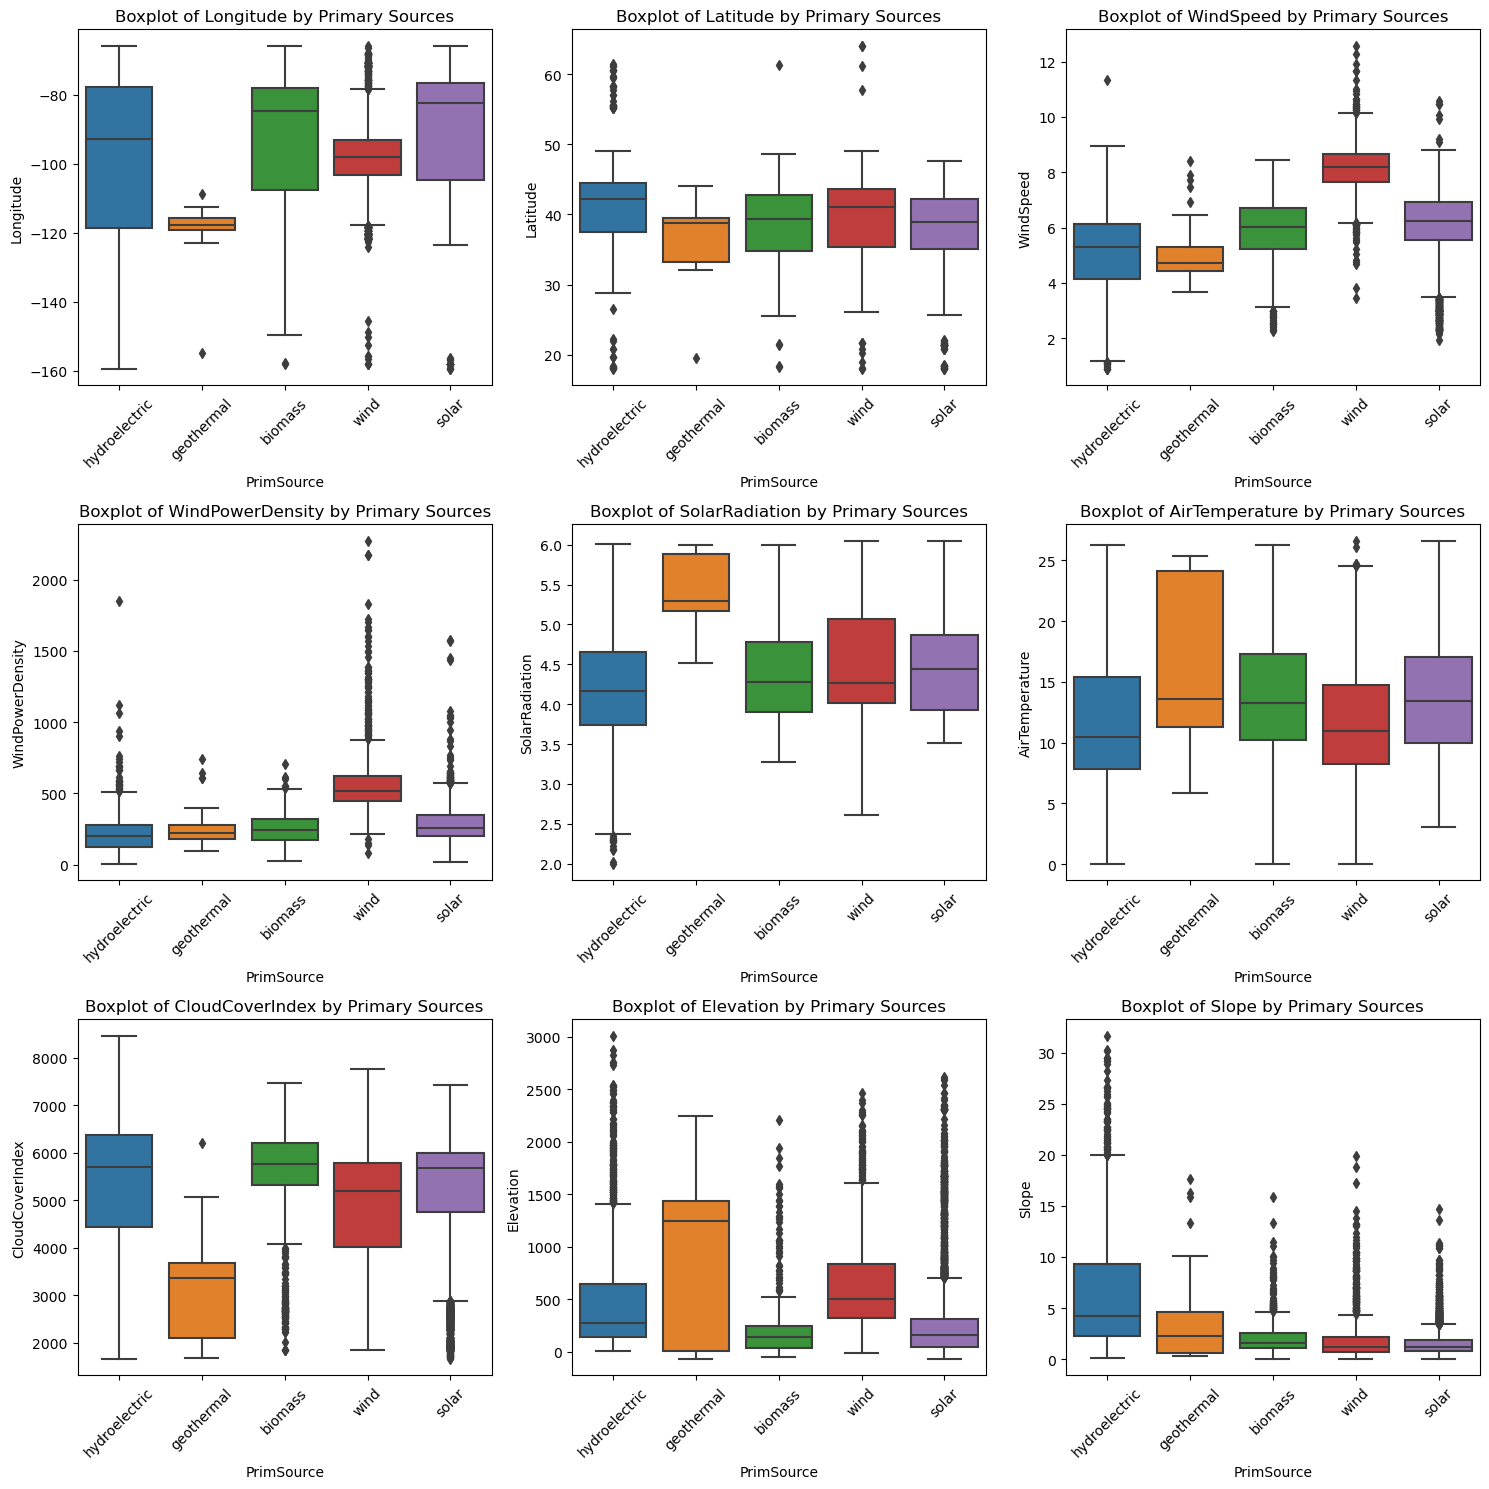

In [78]:
# Set number of rows and columns in subplot
sub_rows = 3
sub_cols = 3

# Set up grid of subplots
plt.subplots(sub_rows, sub_cols, figsize=(sub_cols*5, sub_rows*5))

# Initialize counter
subplot_ctr = 1

# Loop through column names in list
for col in numericalCols:
    
    # Plot subplot in next location in grid
    plt.subplot(sub_rows, sub_cols, subplot_ctr)

    sns.boxplot(x="PrimSource", y=col, data=df_cleaned)
    plt.title(f"Boxplot of {col} by Primary Sources")
    plt.xticks(rotation=45)
    
    # Add 1 to counter
    subplot_ctr += 1

# This ensures the subplots do not overlap
plt.tight_layout()
plt.show()

## Correlation between the Numerical Columns <a id="correlation"></a>

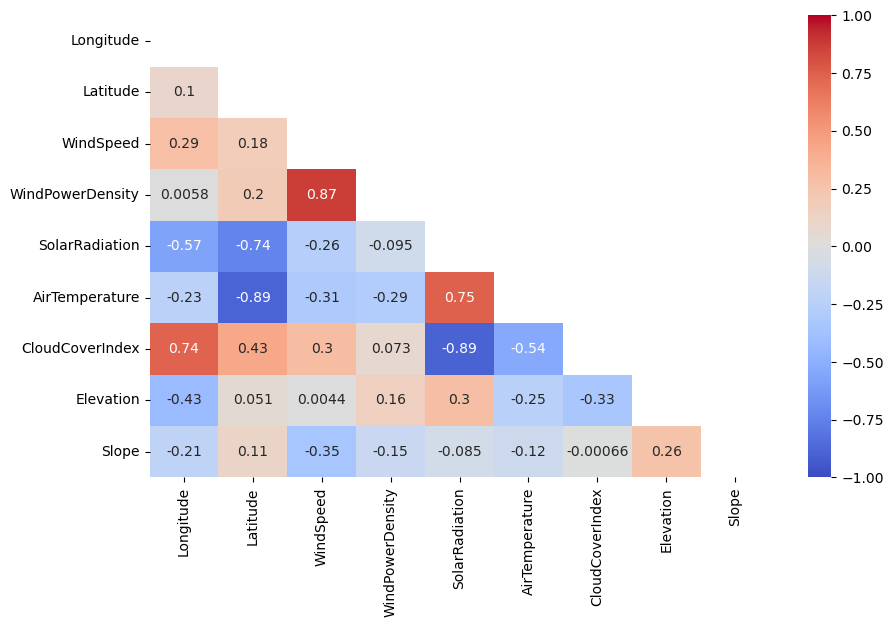

In [79]:
# Generate the correlation matrix for our data
corr_mat = df_cleaned[numericalCols].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr_mat, cmap='coolwarm', center=0, vmin=-1, vmax=1, annot=True, mask=np.triu(corr_mat))
plt.show()

---

## Feature Engineering <a id="feature-engineering"></a>

### OneHotEncoding for `State`

Before we do One Hot Encoding for `State`, let's convert the StateName to State Abberivations.

In [80]:
# Get Crosswalk From Generic Website
cw_location = 'http://app02.clerk.org/menu/ccis/Help/CCIS%20Codes/'
cw_filename = 'state_codes.html'
states = pd.read_html(cw_location + cw_filename)[0]

# Create New Variable With State Abbreviations
state_code_map = dict(zip(states['Description'], 
                          states['Code']))
df_cleaned['StateCode'] = df_cleaned['State'].map(state_code_map)

In [81]:
df_cleaned.sample(5)

,PrimSource,State,Longitude,Latitude,WindSpeed,WindPowerDensity,SolarRadiation,AirTemperature,CloudCoverIndex,Elevation,Slope,StateCode
1640,wind,Minnesota,-96.078611,43.985833,8.593719,583.317566,4.034,7.3750,5479,544.28,1.497737,MN
6636,solar,New Jersey,-74.935560,39.007760,7.585238,475.439606,4.321,13.5000,5012,9.88,0.993705,NJ
5629,solar,Nevada,-114.956428,35.867258,4.236079,205.202850,5.643,21.2500,2313,530.31,0.670316,NV
3432,biomass,Texas,-96.644444,32.648611,6.808177,307.973846,4.750,19.4375,4872,120.82,0.798148,TX
3269,solar,South Carolina,-80.692500,32.913333,5.484569,151.831635,4.700,18.5000,5644,22.33,1.888241,SC


In [82]:
# Number of States in the data set
df_cleaned["StateCode"].nunique()

51

Create dummy variables for `StateCode`

In [83]:
# Create dummies DataFrame
state_dummies = pd.get_dummies(df_cleaned['StateCode'], prefix='State')
state_dummies.head()

,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DE,State_FL,State_GA,State_HI,State_IA,State_ID,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MI,State_MN,State_MO,State_MS,State_MT,State_NC,State_ND,State_NE,State_NH,State_NJ,State_NM,State_NV,State_NY,State_OH,State_OK,State_OR,State_PA,State_PR,State_RI,State_SC,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [84]:
df_cleaned = pd.concat([df_cleaned, state_dummies], axis=1)
df_cleaned.head()

,PrimSource,State,Longitude,Latitude,WindSpeed,WindPowerDensity,SolarRadiation,AirTemperature,CloudCoverIndex,Elevation,Slope,StateCode,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DE,State_FL,State_GA,State_HI,State_IA,State_ID,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MI,State_MN,State_MO,State_MS,State_MT,State_NC,State_ND,State_NE,State_NH,State_NJ,State_NM,State_NV,State_NY,State_OH,State_OK,State_OR,State_PA,State_PR,State_RI,State_SC,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY
0,hydroelectric,Alabama,-87.356823,33.458665,5.295024,154.371399,4.480,17.8125,5525,98.85,5.835022,AL,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,hydroelectric,Alabama,-86.283056,32.583889,5.561799,194.698532,4.704,18.5625,5329,71.87,1.432586,AL,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,hydroelectric,Alabama,-86.052400,33.784500,5.277362,162.491577,4.565,17.2500,5524,155.81,1.295104,AL,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,hydroelectric,Alabama,-87.449500,33.255300,4.935435,123.609497,4.597,18.0000,5481,69.58,5.195643,AL,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,hydroelectric,Alabama,-86.254800,32.618900,5.203608,155.882324,4.694,18.4375,5330,85.85,3.690329,AL,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [85]:
# Drop redundant column
df_cleaned.drop(columns=['State', 'StateCode'] ,inplace=True)

# sanity check
df_cleaned.head()

,PrimSource,Longitude,Latitude,WindSpeed,WindPowerDensity,SolarRadiation,AirTemperature,CloudCoverIndex,Elevation,Slope,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DE,State_FL,State_GA,State_HI,State_IA,State_ID,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MI,State_MN,State_MO,State_MS,State_MT,State_NC,State_ND,State_NE,State_NH,State_NJ,State_NM,State_NV,State_NY,State_OH,State_OK,State_OR,State_PA,State_PR,State_RI,State_SC,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY
0,hydroelectric,-87.356823,33.458665,5.295024,154.371399,4.480,17.8125,5525,98.85,5.835022,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,hydroelectric,-86.283056,32.583889,5.561799,194.698532,4.704,18.5625,5329,71.87,1.432586,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,hydroelectric,-86.052400,33.784500,5.277362,162.491577,4.565,17.2500,5524,155.81,1.295104,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,hydroelectric,-87.449500,33.255300,4.935435,123.609497,4.597,18.0000,5481,69.58,5.195643,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,hydroelectric,-86.254800,32.618900,5.203608,155.882324,4.694,18.4375,5330,85.85,3.690329,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Model Setup

In [86]:
X = df_cleaned.drop(columns=['PrimSource'])
y = df_cleaned['PrimSource']

### Inspect the Multicollinearity using Variance Inflation Factor (VIF)

Multicollinearity is a phenomenon that occurs when predictor variables in a statistical model are highly correlated with each other. In machine learning, multicollinearity can cause issues with the interpretability and stability of the model, as well as reduce the accuracy of predictions.

The VIF is a metric that measures multicollinearity among a group of predictor variables. To compute it, the reciprocal of the variance of a linear regression coefficient estimated using all predictor variables is used. A VIF of 1 means no multicollinearity, while a VIF higher than 1 indicates multicollinearity among the predictor variables.

It is not trival how high of the VIF score is considered significant multicollinearity, however, the standard approach is to avoid having VIF scores above 5.

In [87]:
from statsmodels.regression import linear_model 
import statsmodels.api as sm

# Add constant 
X_with_constant = sm.add_constant(X)

In [88]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# check VIF values for linear regression model
vif_df = pd.DataFrame(
    {'VIF': [variance_inflation_factor(X_with_constant.values, i) for i in range(X_with_constant.shape[1])]}, 
    index=X_with_constant.columns
).sort_values(by='VIF')

In [89]:
vif_df.tail()

,VIF
State_MN,70.821184
State_NC,78.927001
Longitude,154.898384
State_CA,224.285532
const,13456.348636


In [90]:
vif_df.loc[~vif_df.index.str.contains('State')]

,VIF
Slope,2.358392
WindPowerDensity,8.375018
WindSpeed,12.008648
Elevation,13.703217
CloudCoverIndex,31.984141
AirTemperature,33.162327
Latitude,43.611951
SolarRadiation,58.794612
Longitude,154.898384
const,13456.348636


We can see that the state columns and `Longitude` columns have very high VIF values, indicating a significant multicollinearity. It would be appropriate to remove all state variables to ensure minimal multicollinearity. Let's try that and see if that improves the VIF scores of other variables.

In [91]:
non_state_X = X[X.columns[~X.columns.str.contains('State')]]

In [92]:
# Add constant 
X_with_constant = sm.add_constant(non_state_X)

In [93]:
# check VIF values for linear regression model
vif_df = pd.DataFrame(
    {'VIF': [variance_inflation_factor(X_with_constant.values, i) for i in range(X_with_constant.shape[1])]}, 
    index=X_with_constant.columns
).sort_values(by='VIF')

In [94]:
vif_df

,VIF
Slope,1.804976
Longitude,3.195652
Elevation,3.588440
WindPowerDensity,6.952864
WindSpeed,8.227490
AirTemperature,12.810807
Latitude,14.267984
CloudCoverIndex,17.779986
SolarRadiation,35.658229
const,6502.771469


Dropping the dummy variable of `State` significantly lower the VIF scores across the board. Let's continue to drop the columns with high VIF score but avoid dropping `SolarRadiation` as it is the main factor for solar power.

In [95]:
# dropping Latitude
X_removed = non_state_X.drop(columns=['Latitude'])

# Add constant 
X_with_constant = sm.add_constant(X_removed)

# check VIF values for linear regression model
vif_df = pd.DataFrame(
    {'VIF': [variance_inflation_factor(X_with_constant.values, i) for i in range(X_with_constant.shape[1])]}, 
    index=X_with_constant.columns
).sort_values(by='VIF')

# inspect the VIF values
vif_df

,VIF
Slope,1.712819
Longitude,3.053497
Elevation,3.537052
WindPowerDensity,6.705596
WindSpeed,7.848982
AirTemperature,8.157784
CloudCoverIndex,11.361257
SolarRadiation,21.638774
const,1653.535822


In [96]:
# dropping Latitude and CloudCoverIndex
X_removed = non_state_X.drop(columns=['Latitude','CloudCoverIndex'])

# Add constant 
X_with_constant = sm.add_constant(X_removed)

# check VIF values for linear regression model
vif_df = pd.DataFrame(
    {'VIF': [variance_inflation_factor(X_with_constant.values, i) for i in range(X_with_constant.shape[1])]}, 
    index=X_with_constant.columns
).sort_values(by='VIF')

# inspect the VIF values
vif_df

,VIF
Slope,1.702953
Longitude,2.098375
Elevation,2.906853
AirTemperature,6.091624
WindPowerDensity,6.705036
SolarRadiation,7.711133
WindSpeed,7.826242
const,287.152395


In [97]:
# dropping Latitude and CloudCoverIndex and WindPowerDensity
X_removed = non_state_X.drop(columns=['Latitude','CloudCoverIndex', 'WindPowerDensity'])

# Add constant 
X_with_constant = sm.add_constant(X_removed)

# check VIF values for linear regression model
vif_df = pd.DataFrame(
    {'VIF': [variance_inflation_factor(X_with_constant.values, i) for i in range(X_with_constant.shape[1])]}, 
    index=X_with_constant.columns
).sort_values(by='VIF')

# inspect the VIF values
vif_df

,VIF
WindSpeed,1.368285
Slope,1.467848
Longitude,1.907939
Elevation,2.789477
AirTemperature,5.549808
SolarRadiation,6.966006
const,146.127516


In [98]:
# dropping Latitude, CloudCoverIndex, WindPowerDensity, and Longitude
X_removed = non_state_X.drop(columns=['Latitude','CloudCoverIndex', 'WindPowerDensity', 'Longitude'])

# Add constant 
X_with_constant = sm.add_constant(X_removed)

# check VIF values for linear regression model
vif_df = pd.DataFrame(
    {'VIF': [variance_inflation_factor(X_with_constant.values, i) for i in range(X_with_constant.shape[1])]}, 
    index=X_with_constant.columns
).sort_values(by='VIF')

# inspect the VIF values
vif_df

,VIF
WindSpeed,1.337974
Slope,1.405411
Elevation,2.788080
AirTemperature,5.222235
SolarRadiation,5.573581
const,144.134422


Dropping `Longitude` doesn't significantly lower the VIF scores of other columns, and the VIF scores for `AirTemperature` and `SolarRadiation` are still above 5. Let's try dropping `AirTemperature` instead as it is correlated to `SolarRadiation`.

In [99]:
# dropping Latitude, CloudCoverIndex, WindPowerDensity, and AirTemperature
X_removed = non_state_X.drop(columns=['Latitude','CloudCoverIndex', 'WindPowerDensity', 'AirTemperature'])

# Add constant 
X_with_constant = sm.add_constant(X_removed)

# check VIF values for linear regression model
vif_df = pd.DataFrame(
    {'VIF': [variance_inflation_factor(X_with_constant.values, i) for i in range(X_with_constant.shape[1])]}, 
    index=X_with_constant.columns
).sort_values(by='VIF')

# inspect the VIF values
vif_df

,VIF
WindSpeed,1.353106
Elevation,1.389418
Slope,1.403130
SolarRadiation,1.723811
Longitude,1.795324
const,114.834351


That's a great result: dropping `AirTemperature` significantly lower the VIF scores across the board. We now have all our features with VIF scores lower than 5 and actually quite close to 1. Hence, we now have features with low multicollinearity. These features will be used to train the models.

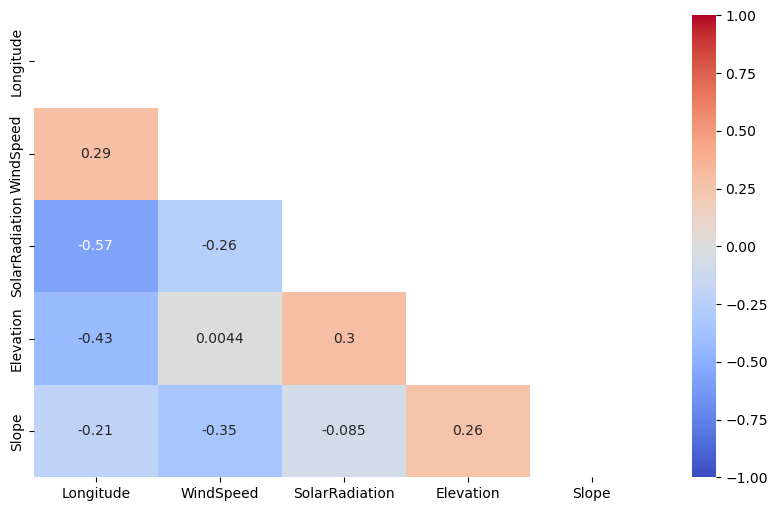

In [100]:
# Generate the correlation matrix for our data
corr_mat = X_removed.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr_mat, cmap='coolwarm', center=0, vmin=-1, vmax=1, annot=True, mask=np.triu(corr_mat))
plt.show()

---

## Baseline Logistic Regression Modelling <a id="baseline-model"></a>

In [101]:
y.value_counts(normalize=True)

solar            0.574859
hydroelectric    0.179892
wind             0.159348
biomass          0.078069
geothermal       0.007833
Name: PrimSource, dtype: float64

57% of renewable power plants fall with primary energy source of solar, meaning that a dummy model that always predicts a location to belong to solar, will be correct 57% of the times.

Since the primary source classes are imbalanced, we will make primary source as a binary variable: Solar or non-solar.

In [102]:
y_binary = y.map({
    'solar': 'solar',
    'hydroelectric': 'non-solar',
    'wind': 'non-solar',
    'biomass': 'non-solar',
    'geothermal': 'non-solar'
})
y_binary.value_counts(normalize=True)

solar        0.574859
non-solar    0.425141
Name: PrimSource, dtype: float64

Before we perform the baseline logistic regression, let's inspect our dataframe to check for duplicate rows and missing values.

In [103]:
df_cleaned = pd.concat([X_removed, y_binary], axis=1)

In [104]:
df_shape = df_cleaned.shape
cat_cols = len(df_cleaned.select_dtypes('object').columns)
num_cols = len(df_cleaned.select_dtypes('number').columns)

print(f'Rows: {df_shape[0]}')
print(f'Columns: {df_shape[1]}\n')

print(f'Total duplicate rows: {df_cleaned.duplicated().sum()}')
print(f'Percentage duplicate rows: {df_cleaned.duplicated().mean()}% \n')

print(f'Total null values: {df_cleaned.isna().sum().sum()}')
print(f'Percentage null vales: {df_cleaned.isna().mean().sum()}% \n')

df_cleaned.info()

print("\n")

print(f'Number of categorical columns: {cat_cols}')
print(f'Number of numerical columns: {num_cols}')

Rows: 7788
Columns: 6

Total duplicate rows: 4
Percentage duplicate rows: 0.0005136106831022085% 

Total null values: 0
Percentage null vales: 0.0% 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7788 entries, 0 to 7787
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Longitude       7788 non-null   float64
 1   WindSpeed       7788 non-null   float64
 2   SolarRadiation  7788 non-null   float64
 3   Elevation       7788 non-null   float64
 4   Slope           7788 non-null   float64
 5   PrimSource      7788 non-null   object 
dtypes: float64(5), object(1)
memory usage: 365.2+ KB


Number of categorical columns: 1
Number of numerical columns: 5


There are four duplicate rows, let's drop them.

In [105]:
prev_shape = df_cleaned.shape[0]
df_cleaned.drop_duplicates(inplace=True)
current_shape = df_cleaned.shape[0]
print(f'The number of rows in the DataFrame has decreased from {prev_shape} to {current_shape}')

# sanity check
print(f'Total duplicate rows: {df_cleaned.duplicated().sum()}')

The number of rows in the DataFrame has decreased from 7788 to 7784
Total duplicate rows: 0


In [106]:
df_shape = df_cleaned.shape
cat_cols = len(df_cleaned.select_dtypes('object').columns)
num_cols = len(df_cleaned.select_dtypes('number').columns)

print(f'Rows: {df_shape[0]}')
print(f'Columns: {df_shape[1]}\n')

print(f'Total duplicate rows: {df_cleaned.duplicated().sum()}')
print(f'Percentage duplicate rows: {df_cleaned.duplicated().mean()}% \n')

print(f'Total null values: {df_cleaned.isna().sum().sum()}')
print(f'Percentage null vales: {df_cleaned.isna().mean().sum()}% \n')

df_cleaned.info()

print("\n")

print(f'Number of categorical columns: {cat_cols}')
print(f'Number of numerical columns: {num_cols}')

Rows: 7784
Columns: 6

Total duplicate rows: 0
Percentage duplicate rows: 0.0% 

Total null values: 0
Percentage null vales: 0.0% 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7784 entries, 0 to 7787
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Longitude       7784 non-null   float64
 1   WindSpeed       7784 non-null   float64
 2   SolarRadiation  7784 non-null   float64
 3   Elevation       7784 non-null   float64
 4   Slope           7784 non-null   float64
 5   PrimSource      7784 non-null   object 
dtypes: float64(5), object(1)
memory usage: 425.7+ KB


Number of categorical columns: 1
Number of numerical columns: 5


Now, the dataframe is completely cleaned. Let's also rename `PrimSource` to `isSolar` and map `solar` to value of 1 and `non-solar` to value of 0.

In [107]:
# rename PrimSource to isSolar
df_cleaned.rename(columns={'PrimSource': 'isSolar'}, inplace=True)

# sanity check
df_cleaned.head(5)

,Longitude,WindSpeed,SolarRadiation,Elevation,Slope,isSolar
0,-87.356823,5.295024,4.480,98.85,5.835022,non-solar
1,-86.283056,5.561799,4.704,71.87,1.432586,non-solar
2,-86.052400,5.277362,4.565,155.81,1.295104,non-solar
3,-87.449500,4.935435,4.597,69.58,5.195643,non-solar
4,-86.254800,5.203608,4.694,85.85,3.690329,non-solar


In [108]:
# Convert isSolar to a binary variable
df_cleaned['isSolar'] = df_cleaned['isSolar'].map({
    'solar': 1,
    'non-solar': 0
})

# sanity check
df_cleaned['isSolar'].value_counts(normalize=True)

1    0.574769
0    0.425231
Name: isSolar, dtype: float64

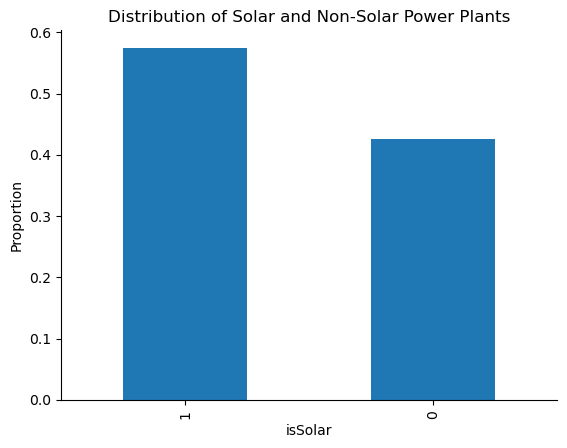

In [116]:
df_cleaned['isSolar'].value_counts(normalize=True).plot(kind="bar")
plt.title("Distribution of Solar and Non-Solar Power Plants")
plt.xlabel('isSolar')
plt.ylabel('Proportion')
sns.despine()
plt.show()

With the updated DataFrame, let's set up our model again:

In [109]:
X = df_cleaned.drop(columns='isSolar')
y = df_cleaned['isSolar']

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)

print(f'Shape of test set: {X_test.shape}')
print(f'Shape of train set: {X_train.shape}')

from sklearn.linear_model import LogisticRegression

# Instantiate the model
logreg = LogisticRegression(max_iter=10000, random_state=1)

# Fit the model
logreg.fit(X_train, y_train)

# Scores
print(f'The baseline model achieved a train accuracy of {logreg.score(X_train, y_train):.4f}.')
print(f'The baseline model achieved a test accuracy of {logreg.score(X_test, y_test):.4f}.')


Shape of test set: (1557, 5)
Shape of train set: (6227, 5)
The baseline model achieved a train accuracy of 0.7299.
The baseline model achieved a test accuracy of 0.7168.


The baseline regression model has a decent accuracy of ~72% with little overfitting. Let's look at the confusion matrix and the classification reports.

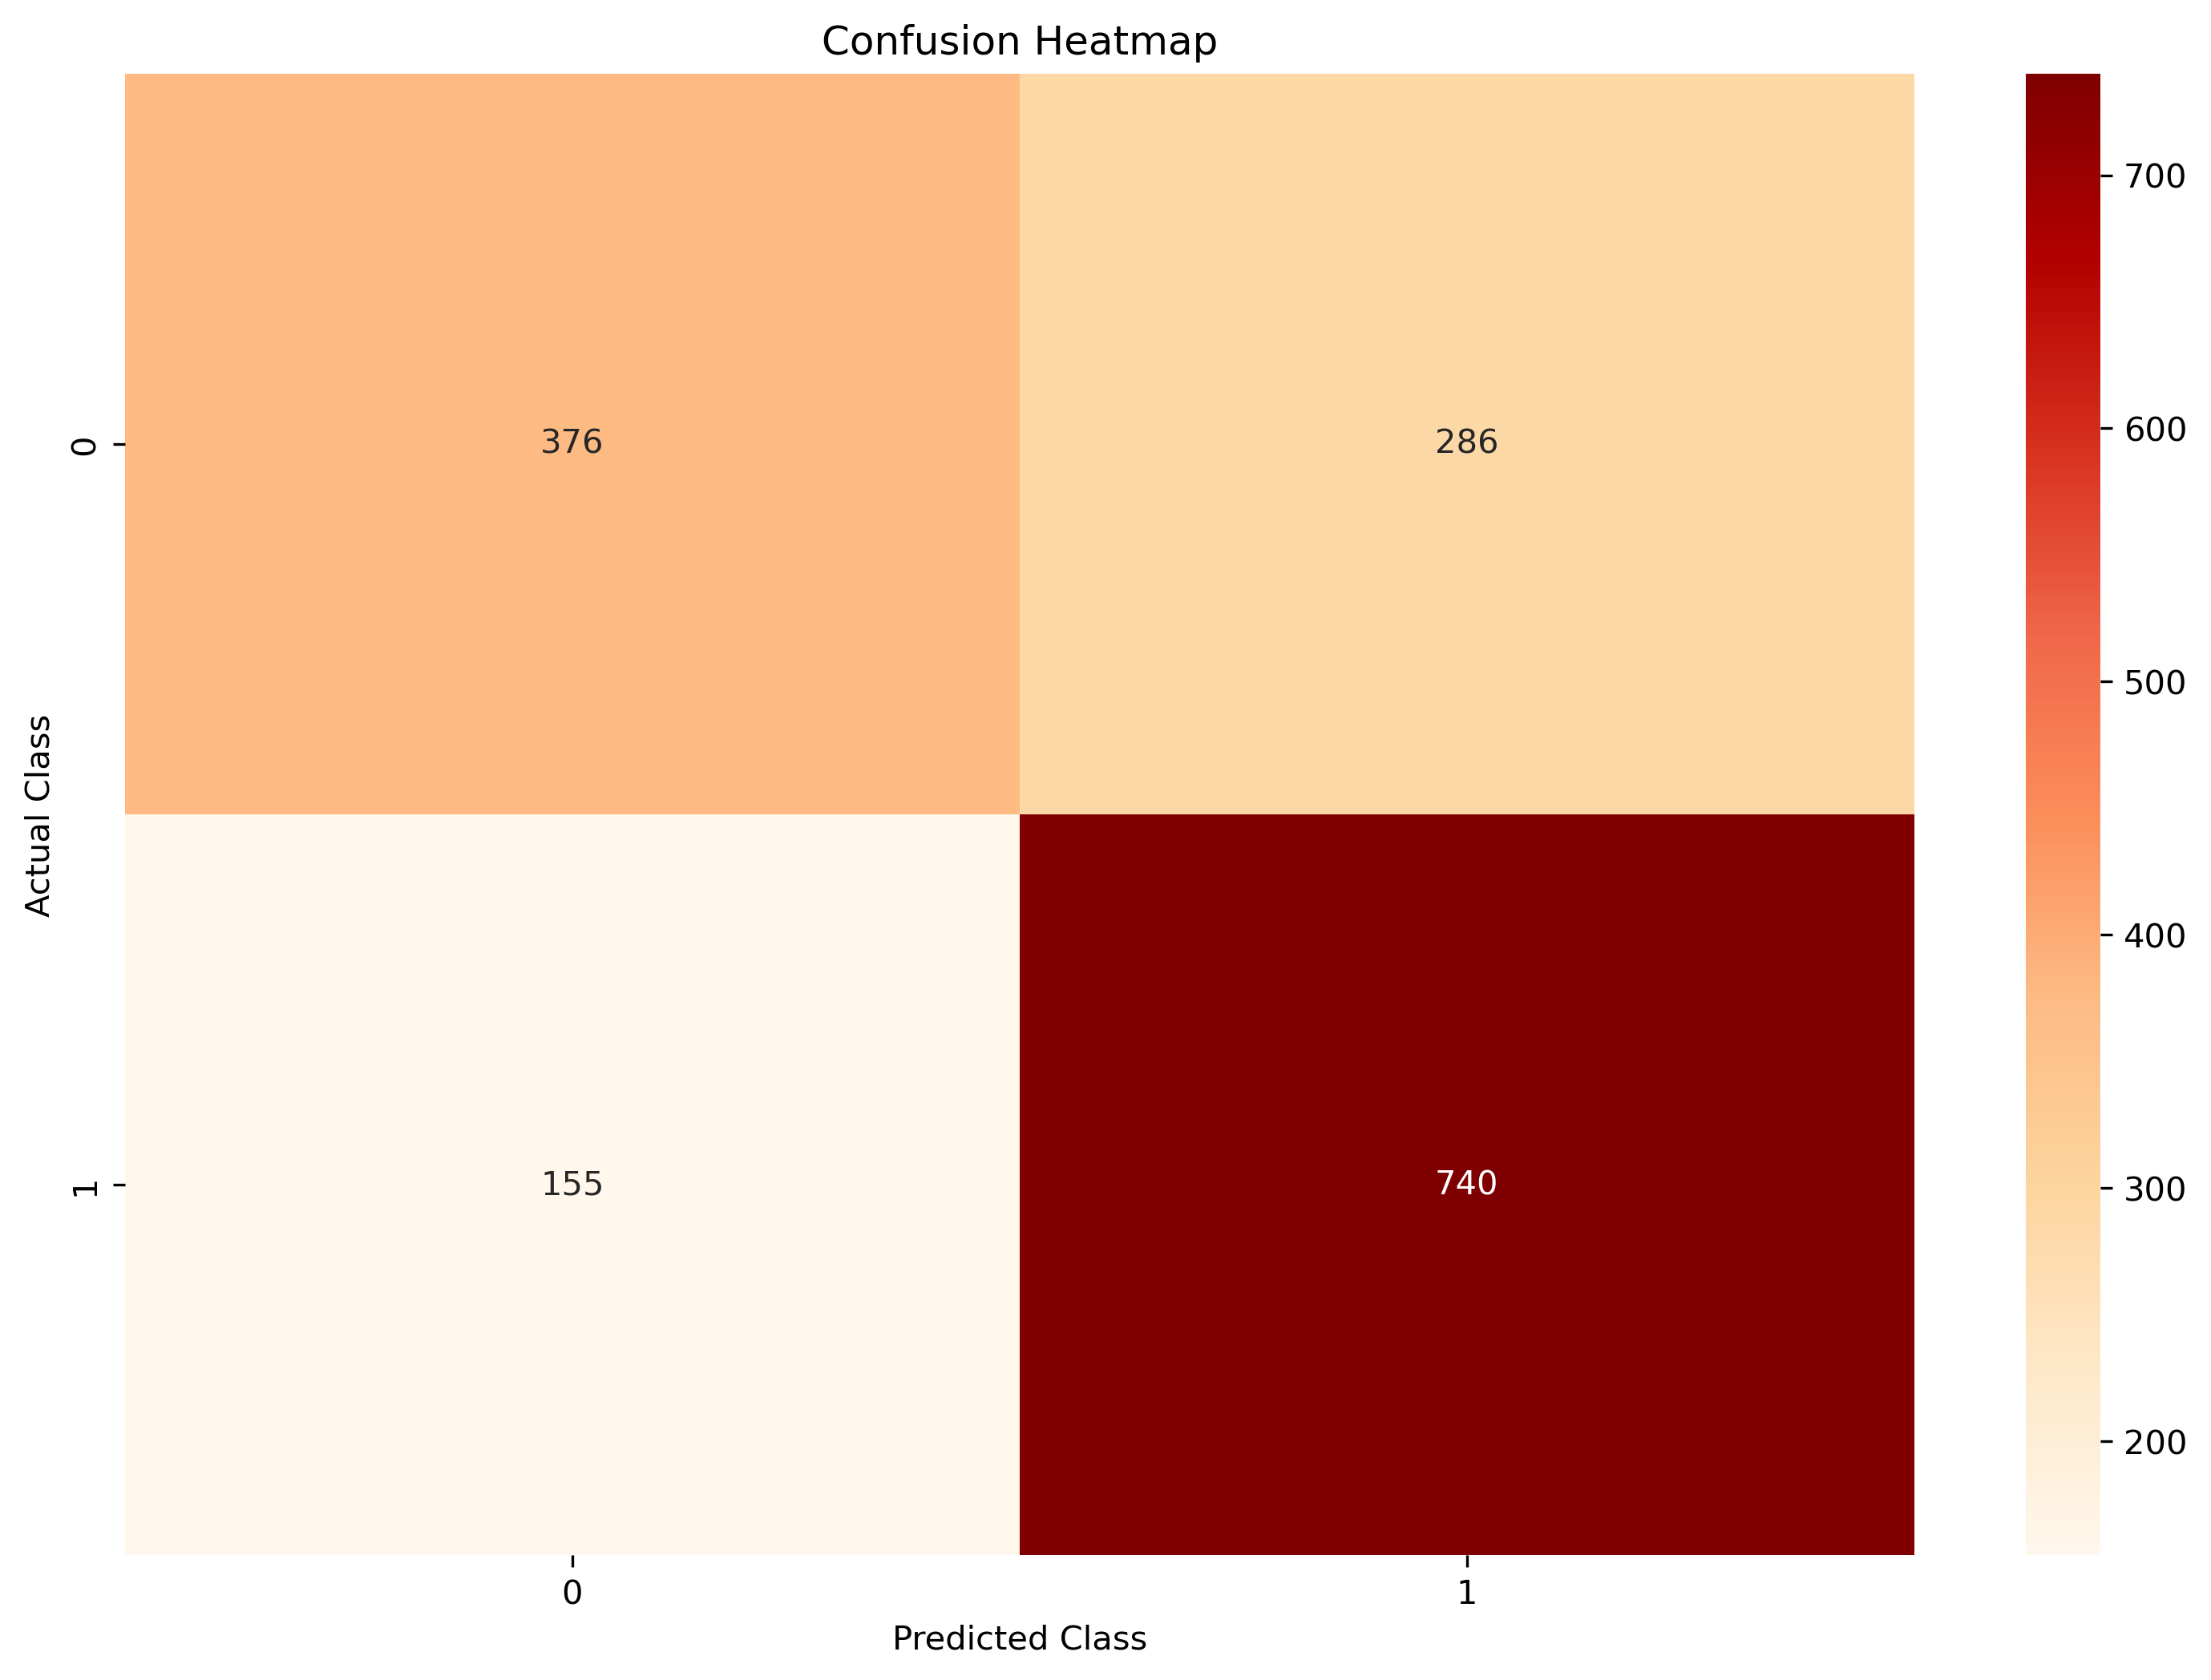

              precision    recall  f1-score   support

           0       0.71      0.57      0.63       662
           1       0.72      0.83      0.77       895

    accuracy                           0.72      1557
   macro avg       0.71      0.70      0.70      1557
weighted avg       0.72      0.72      0.71      1557



In [112]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Make classifications based on the test features, and assign the classifications to a variable
y_pred = logreg.predict(X_test)

predictions = y_test.unique()
predictions.sort()

# Build the confusion matrix as a dataframe
confusion_df = pd.DataFrame(confusion_matrix(y_test, y_pred))
confusion_df.index = [i for i in predictions]
confusion_df.columns = [i for i in predictions]

# Heatmap of the above
plt.figure(figsize=(12, 8), dpi=300)
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='OrRd') # Passing in fmt='d' prevents the counts from being displayed in scientific notation
plt.title('Confusion Heatmap')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

print(classification_report(y_test, y_pred))

In [113]:
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, roc_auc_score

# Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
print('ROC AUC Score : ' + str(roc_auc_score(y_test,y_pred)))

Accuracy Score : 0.7167630057803468
Precision Score : 0.7212475633528265
Recall Score : 0.8268156424581006
F1 Score : 0.7704320666319625
ROC AUC Score : 0.6973957366369052


Let's discuss if we want to focus on the Precision or the Recall:

Higher precision means lower false positive - avoiding the consequence of having false positive in prediction
Higher recall means lower false negative - avoiding the consequence of having false negative in prediction

In this project, 
- False positive: Predicted to be suitable for solar energy but in fact it should be non-solar
- False negative: Predicted to be suitable for non-solar energy (e.g. wind, geothermal, biomass, hydroelectic) but in fact it should be solar

My arguement is we want to limit False negative predictions because we want to ensure we capture the locations that are potentially suitable for solar energy and we can perform further evaluation. On the contrary, we might not inspect further if a location is considered as not suitable for solar energy.

To conclude, we will focus on **increasing the recall of the models**.

---

## Save the final DataFrame to CSV for next notebook

In [117]:
# Write the DataFrame to CSV file
df_cleaned.to_csv("./data/capstone_data_cleaned_for_model.csv", index=False)